Copyright **`(c)`** 2024 Giovanni Squillero `<giovanni.squillero@polito.it>`  
[`https://github.com/squillero/computational-intelligence`](https://github.com/squillero/computational-intelligence)  
Free for personal or classroom use; see [`LICENSE.md`](https://github.com/squillero/computational-intelligence/blob/master/LICENSE.md) for details.  

# Set Cover problem

See: https://en.wikipedia.org/wiki/Set_cover_problem

In [449]:
from random import random, seed
from itertools import accumulate
from itertools import product
import numpy as np
from matplotlib import pyplot as plt

from icecream import ic

In [450]:
results = []


## Reproducible Initialization

If you want to get reproducible results, use `rng` (and restart the kernel); for non-reproducible ones, use `np.random`.

In [451]:
UNIVERSE_SIZE = 10_000
NUM_SETS = 1000
DENSITY = 0.2

MAX_STEPS = 10_000
rng = np.random.Generator(np.random.PCG64([UNIVERSE_SIZE, NUM_SETS, int(10_000 * DENSITY)]))

In [452]:
# DON'T EDIT THESE LINES!

SETS = np.random.random((NUM_SETS, UNIVERSE_SIZE)) < DENSITY
for s in range(UNIVERSE_SIZE):
    if not np.any(SETS[:, s]):
        SETS[np.random.randint(NUM_SETS), s] = True
COSTS = np.pow(SETS.sum(axis=1), 1.1)

## Helper Functions

In [453]:
def valid(solution):
    """Checks wether solution is valid (ie. covers all universe)"""
    return np.all(np.logical_or.reduce(SETS[solution]))


def cost(solution):
    """Returns the cost of a solution (to be minimized)"""
    return COSTS[solution].sum()



## Have Fun!

In [454]:
# A dumb solution of "all" sets
solution = np.full(NUM_SETS, True)
valid(solution), cost(solution)

(np.True_, np.float64(4276261.246112827))

In [455]:
# A random solution with random 50% of the sets
#solution = rng.random(NUM_SETS) < .5
#valid(solution), cost(solution)

In [456]:
def fitness(solution: np.ndarray):
    return valid(solution), -cost(solution)

In [457]:
#rng.

## SIMPLE RHMC


In [458]:
def single_tweak(solution: np.ndarray) -> np.ndarray:
    new_solution = solution.copy()

    #pos = np.random.randint(NUM_SETS)
    pos = rng.integers(0, NUM_SETS)
    new_solution[pos] = not new_solution[pos]
    
    return new_solution

def multi_tweak(solution: np.ndarray) -> np.ndarray:
    mask = rng.random(NUM_SETS) < .01
    new_solution = np.logical_xor(solution, mask)
    
    return new_solution


ic| fitness_solution: (np.True_, np.float64(-2133867.089352033))
ic| fitness_solution: (np.True_, np.float64(-530624.7189386132))


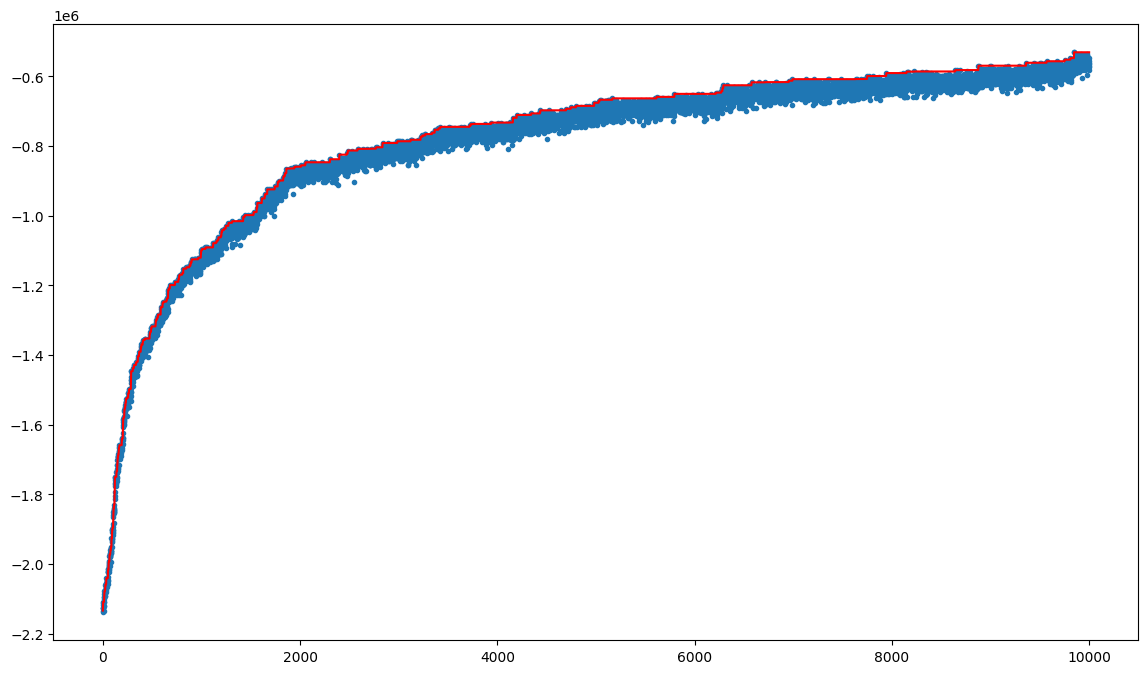

In [459]:
current_solution = rng.random(NUM_SETS) < 0.5
fitness_solution = fitness(current_solution)
history = [float(fitness_solution[1])]
ic(fitness_solution)

steps =  0

#tweak = single_tweak
tweak = multi_tweak
for steps in range(MAX_STEPS):
    

    #tweak  
    new_solution = tweak(current_solution)   
    f = fitness(new_solution)
    history.append(float(f[1]))
    if(f> fitness_solution):
       # ic(steps, cost(current_solution), cost(new_solution))
        fitness_solution = fitness(new_solution)
        current_solution = new_solution
   

plt.figure(figsize=(14, 8))
plt.plot(
    range(len(history)),
    list(accumulate(history, max)),
    color="red",
)
_ = plt.scatter(range(len(history)), history, marker=".")


ic(fitness_solution)

results.append((1,fitness_solution[1]))

## improved RHMC with Stength

In [460]:
def multi_tweak_strength(solution: np.ndarray, strength: float = 0.3) -> np.ndarray:
    mask = rng.random(NUM_SETS) < strength
    if (not np.any(mask)): #if all false add 1 true
        mask[np.random.randint(NUM_SETS)] = True

    new_solution = np.logical_xor(solution, mask)
    
    return new_solution


ic| fitness_solution: (np.True_, np.float64(-2147642.3261499954))
ic| history.index(max(history)): 8858
ic| fitness_solution: (np.True_, np.float64(-123356.13330952077))


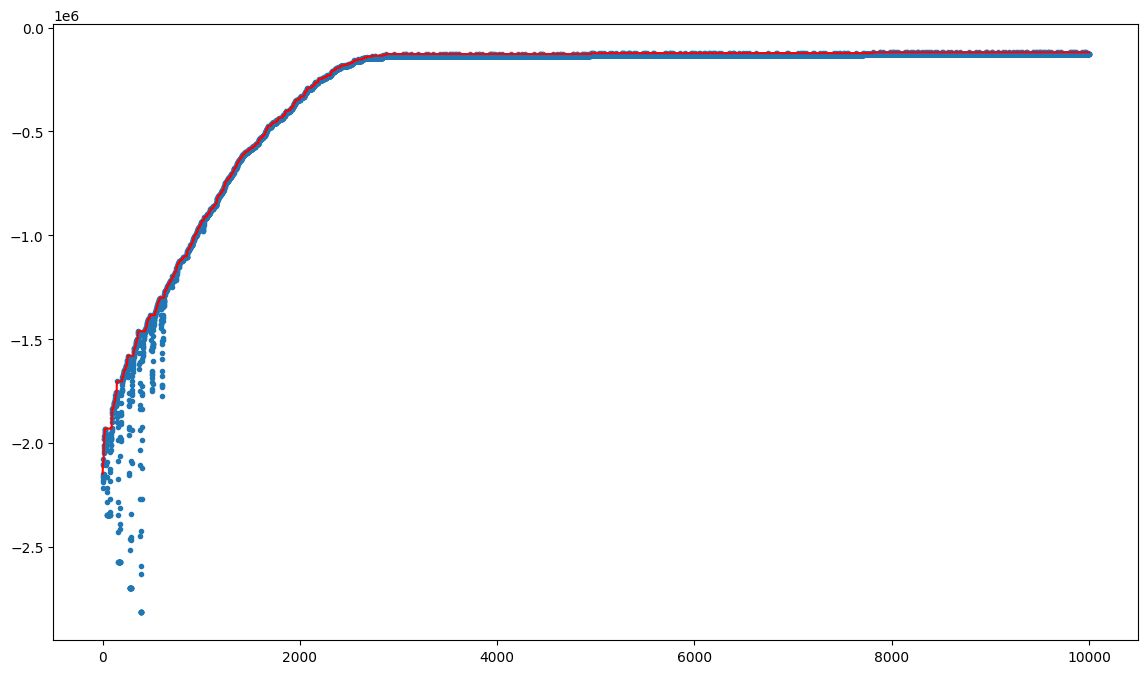

In [461]:
BUFFER_SIZE = 50 #rule 1/5

current_solution = rng.random(NUM_SETS) < 0.5
fitness_solution = fitness(current_solution)
history = [float(fitness_solution[1])]
ic(fitness_solution)

strength = 0.5
buffer  = list()


for steps in range(MAX_STEPS):
    #SEELF ADAPTIVE
#    if steps % 1000:
#       strength /= 2

    #tweak  
    new_solution = multi_tweak_strength(current_solution, strength)   
    f = fitness(new_solution)
    history.append(float(f[1]))
    buffer.append(f > fitness_solution)
    #take only the last BUFFER_SIZE elements
    buffer = buffer[-BUFFER_SIZE:]
    #if the fitness increased by 12% increase strength
    if (sum(buffer) > 10):
        strength *= 1.2
    elif (sum(buffer) < 10 ):
        strength /= 1.2

    if(f> fitness_solution):
       # ic(steps, cost(current_solution), cost(new_solution))
        fitness_solution = fitness(new_solution)
        current_solution = new_solution
   

plt.figure(figsize=(14, 8))
plt.plot(
    range(len(history)),
    list(accumulate(history, max)),
    color="red",
)
_ = plt.scatter(range(len(history)), history, marker=".")

ic(history.index(max(history)))
ic(fitness_solution)

results.append((2,fitness_solution[1]))

## my RHMC

In [462]:
#multi mutation tweak with probability of 20%
def tweak(solution):
    new_solution = solution.copy()
    index = None
    while index is None or np.random.random() < 0.2:
        index = np.random.randint(0, NUM_SETS)
        new_solution[index] = not new_solution[index]
    return new_solution


ic| solution_fiteness: (np.True_, np.float64(-2135892.9236099413))
ic| fitness(current_solution): (np.True_, np.float64(-126475.06774977251))


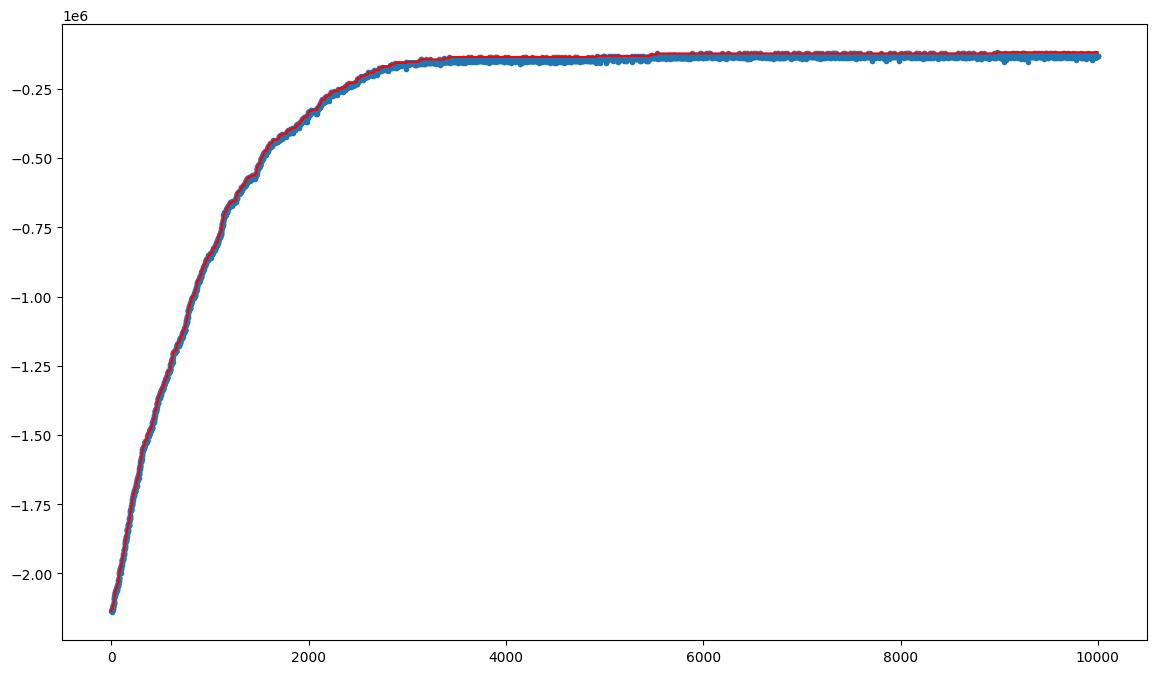

In [463]:
current_solution = rng.random(NUM_SETS) < 0.5
solution_fiteness = fitness(current_solution)
history = [float(solution_fiteness[1])]
ic(solution_fiteness)


for steps in range(MAX_STEPS):
    
    #tweak
    new_solution = tweak(current_solution)   
    f = fitness(new_solution)
    if(f > solution_fiteness):
        #ic(steps, cost(current_solution), cost(new_solution))
        current_solution = new_solution
        solution_fiteness = f
    history.append(float(f[1]))

plt.figure(figsize=(14, 8))
plt.plot(
    range(len(history)),
    list(accumulate(history, max)),
    color="red",
)
_ = plt.scatter(range(len(history)), history, marker=".")

ic(fitness(current_solution))

results.append((3,solution_fiteness[1]))

## simulated annealing

In [464]:
def simulated_annealing(solution_fitness, new_solution_fitness, temp):
    accepting_probability = np.exp(-(solution_fitness[1] - new_solution_fitness[1]) / temp)
    #ic(solution_fitness[1] - new_solution_fitness[1])
    #ic(accepting_probability)
    return np.random.random() < accepting_probability


ic| solution_fiteness: (np.True_, np.float64(-2204421.602773117))
ic| fitness(current_solution): (np.True_, np.float64(-123865.81834122408))


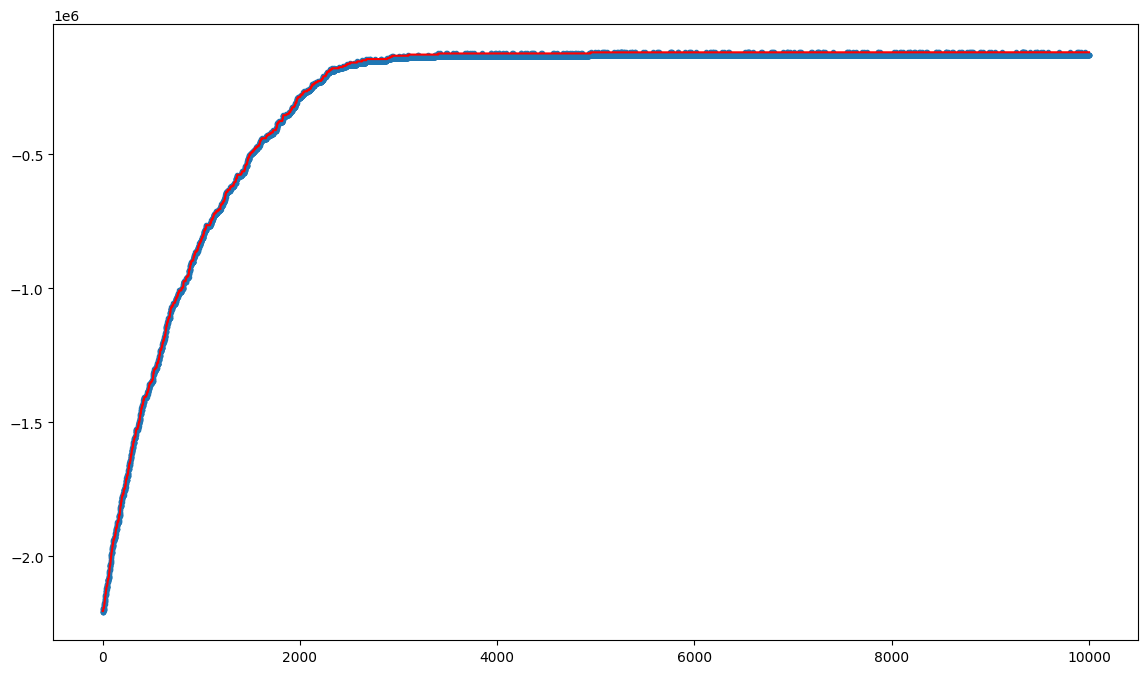

In [465]:
current_solution = rng.random(NUM_SETS) < 0.5
solution_fiteness = fitness(current_solution)
history = [solution_fiteness[1]]
ic(solution_fiteness)



temp = 1565
for steps in range(MAX_STEPS):
    #tweak 
    new_solution = single_tweak(current_solution)   
    f = fitness(new_solution)
    if(f > solution_fiteness or (f[0]  and simulated_annealing(solution_fiteness, f, temp))):
        #ic(steps, cost(current_solution), cost(new_solution))
        current_solution = new_solution
        solution_fiteness = f
    history.append(float(f[1]))
    temp*=0.99




plt.figure(figsize=(14, 8))
plt.plot(
    range(len(history)),
    list(accumulate(history, max)),
    color="red",
)
_ = plt.scatter(range(len(history)), history, marker=".")

ic(fitness(current_solution))


results.append((4,solution_fiteness[1]))

In [468]:
#sort results, array of tuples, where the first element is the algorithm and the second is the fitness

sorted_results = sorted(results, key=lambda x: x[1], reverse = True)
ic(sorted_results)

ic| sorted_results: [(1, np.float64(-530624.7189386132)),
                     (3, np.float64(-126475.06774977251)),
                     (4, np.float64(-123865.81834122408)),
                     (2, np.float64(-123356.13330952077))]


[(1, np.float64(-530624.7189386132)),
 (3, np.float64(-126475.06774977251)),
 (4, np.float64(-123865.81834122408)),
 (2, np.float64(-123356.13330952077))]